In [1]:
import sympy as sp
from sympy.physics import mechanics

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# our module
import multipendulum as mp

# make output look nice
sp.init_printing()

In calculating Lyapunov exponents, we observed some interesting behavior, illustrated by the following example.

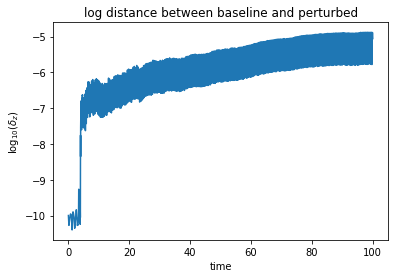

In [7]:
baseline = mp.MultiPendulum(2)
baseline.set_initial_conditions((0.085,-0.075), (0,0), degrees=False, eigenmodes=False)
baseline.integrate_kane()

modetwo = mp.MultiPendulum(2)
modetwo.set_initial_conditions((0.085,-0.075), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.perturb(1.0e-10)
modetwo.integrate_kane()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

plt.plot(baseline.times, np.log10(deltaz))
plt.xlabel("time")
plt.ylabel(r"$\log_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed");

The case we're looking at here is not chaotic, so we don't expect extreme sensitivity to initial conditions (we don't have dissipation, so we don't expect a negative Liapunov exponent, but the dependence on initial conditions should be weak). Over the course of the whole simulation, this appears to be true; after 100 seconds of simulation time, the distance betwen the two cases is still quite small. However we notice a sudden, rapid increase in distance between the two trajectories early in the simulation. After that initial jump, growth in $\delta_z$ is much more modest.

The question is, What is the jump? Possible answers fall into two categories:

* Something numerical
  * truncation error from the integrator
  * precision issues with `lambdify`
  * precision issues with `np.linalg.solve` (used in the rhs of the integrator)
* Something physical
  * related to dynamics
  * related to (slight) differences in energy
  * resonance or something like it


Before we dig into each of these possibilities in detail, let's try to gather some more information about the jump. First, what does it look like if we zoom in?

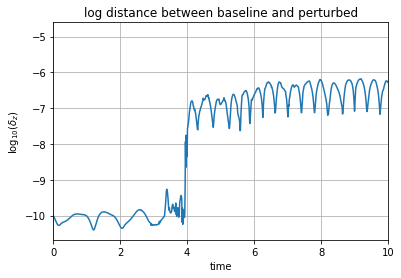

In [8]:
plt.plot(baseline.times, np.log10(deltaz))
plt.xlabel("time")
plt.ylabel(r"$\log_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
plt.grid()
plt.xlim(0,10);

First thing to notice: the difference between these two simulations is *small*. Initially, it's about $10^{-10}$; after the jump it's still down around $10^{-7}$. If the two quantities are plotted on top of each other, it's impossible to see the difference.  Is energy conserved while this is going on?

In [6]:
baseline.build_energy_func()
baseline.make_energy_timeseries()
modetwo.build_energy_func()
modetwo.make_energy_timeseries()

plt.plot(baseline.times, baseline.energy_timeseries['E']/baseline.energy_timeseries['E'][0]-1.0)
plt.plot(modetwo.times, modetwo.energy_timeseries['E']/modetwo.energy_timeseries['E'][0]-1.0)
plt.ylabel('Fractional energy deviation')
plt.xlabel('time');

NameError: name 'p_1' is not defined

Not well enough. That could be part of the problem. More interesting, the non-conservation of energy is different! Zooming in...

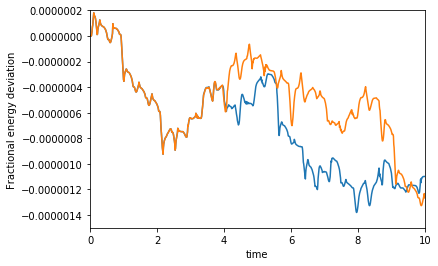

In [5]:
plt.plot(baseline.times, baseline.energy_timeseries['E']/baseline.energy_timeseries['E'][0]-1.0)
plt.plot(modetwo.times, modetwo.energy_timeseries['E']/modetwo.energy_timeseries['E'][0]-1.0)
plt.ylabel('Fractional energy deviation')
plt.xlim(0,10)
plt.xlabel('time');
plt.ylim(-1.5e-6, 2.0e-7)

The real deviation starts about the same time as the jump, so they seem to be related. I suppose it should have been obvious that would be the case. No telling yet which is more closely tied to the cause of the problem, though. Also, this picture complicates the diagnosis, since once the two trajectories are on different constant-energy manifolds we don't have guarantees about how close they should stay to one another.

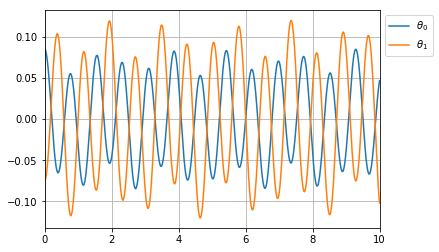

In [6]:
plt.plot(baseline.times, baseline.timeseries[:,0], label=r"$\theta_0$")
plt.plot(baseline.times, baseline.timeseries[:,1], label=r"$\theta_1$")
#plt.plot(baseline.times, baseline.timeseries[:,2], label=r"$\dot{\theta_0}$")
#plt.plot(baseline.times, baseline.timeseries[:,3], label=r"$\dot{\theta_1}$")
plt.xlim(0, 10)
leg = plt.legend(loc="upper left")
leg.set_bbox_to_anchor((1,1))
plt.grid()

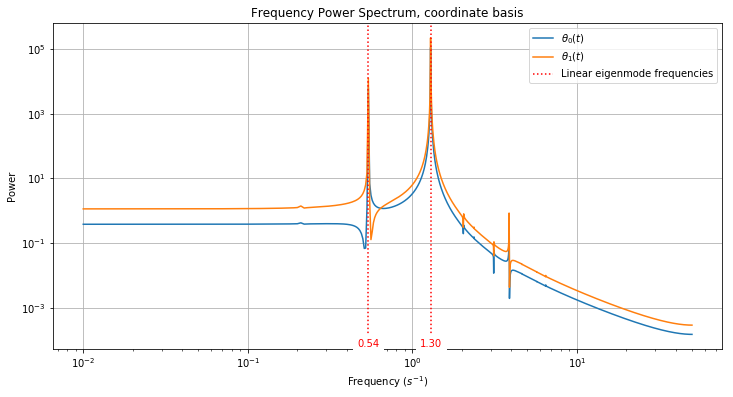

In [7]:
baseline.powerspectrum();
plt.grid()

In [8]:
from numpy.fft import rfft, rfftfreq

def powerspectrum(times, series):
    spacing = (np.max(times) - np.min(times))/len(times)
    frequencies = rfftfreq(len(times), spacing)

    fig, ax = plt.subplots()
    fig.set_figwidth(12)
    fig.set_figheight(6)

    amplitude = rfft(series)
    power = np.abs(amplitude)**2
    ax.plot(frequencies, power)

    ax.set_ylabel("Power")
    ax.set_xlabel("Frequency ($s^{-1}$)")
    ax.loglog()
#    ax.set_title(title)
#    ylim = ax.get_ylim()
#    for freq in markerfreqs:
#        line, = ax.plot([freq, freq], ylim, ":r")
#    line.set_label("Linear eigenmode frequencies")
#    ax.set_ylim(ylim)
#    ax.legend()
    return fig



What sort of frequency spectrum do we have?

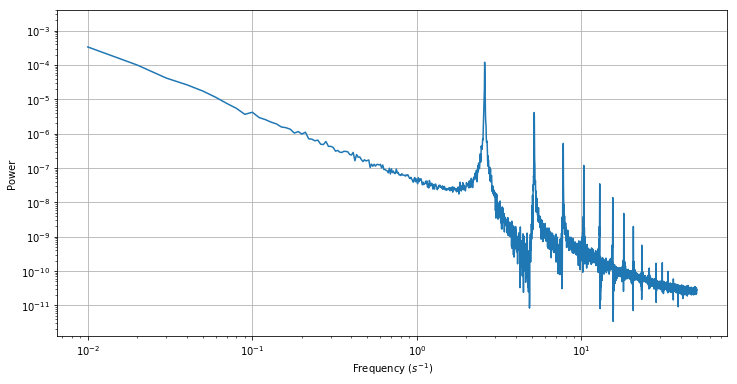

In [9]:
powerspectrum(baseline.times, deltaz);
plt.grid()

## Does changing the perturbation size affect the jump?

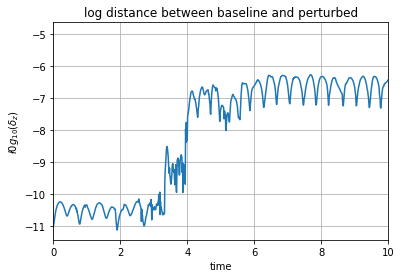

In [10]:
modetwo = mp.MultiPendulum(2)
modetwo.set_initial_conditions((0.085,-0.075+1.0e-11), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

plt.plot(baseline.times, np.log10(deltaz))
plt.xlabel("time")
plt.ylabel(r"$\l0g_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
plt.xlim(0,10)
plt.grid()

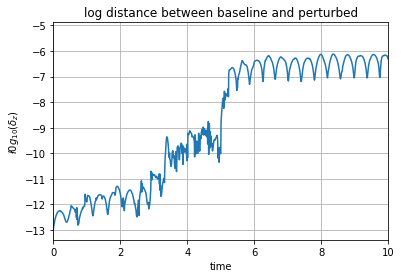

In [11]:
modetwo = mp.MultiPendulum(2)
modetwo.set_initial_conditions((0.085,-0.075+1.0e-13), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

plt.plot(baseline.times, np.log10(deltaz))
plt.xlabel("time")
plt.ylabel(r"$\l0g_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
plt.xlim(0,10)
plt.grid()

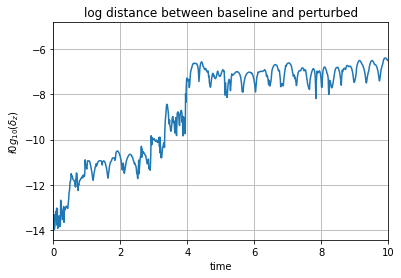

In [12]:
modetwo = mp.MultiPendulum(2)
modetwo.set_initial_conditions((0.085,-0.075+1.0e-14), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

plt.plot(baseline.times, np.log10(deltaz))
plt.xlabel("time")
plt.ylabel(r"$\l0g_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
plt.xlim(0,10)
plt.grid()

With a perturbation of 1e-13, the jump happens at a different time, but the magnitude of the difference after the jump stays the same.

## Do we still get the jump if we start in an eigenmode state?

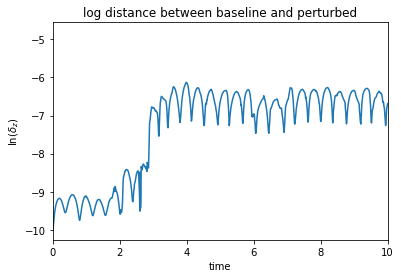

In [16]:
baseline = mp.MultiPendulum(2)
baseline.set_initial_conditions((-np.sqrt(2)/2*0.1, 0.1), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()

modetwo = mp.MultiPendulum(2)
modetwo.set_initial_conditions((-np.sqrt(2)/2*0.1+1.0e-10,0.1), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

plt.plot(baseline.times, np.log10(deltaz))
plt.xlabel("time")
plt.ylabel(r"$\ln(\delta_z)$")
plt.title("log distance between baseline and perturbed")
plt.xlim(0,10)

Uh, yeah. Frequencies?

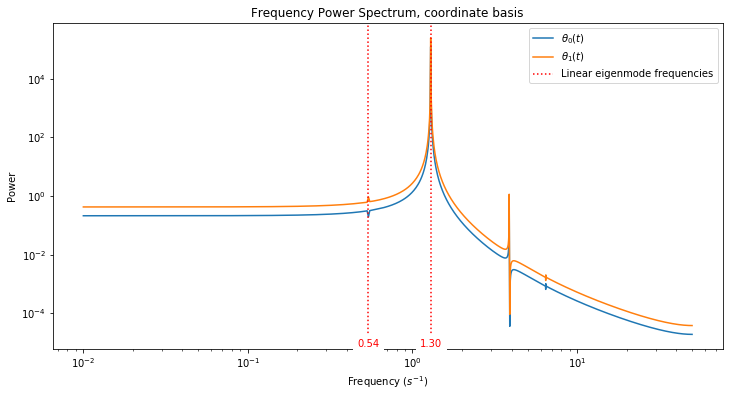

In [17]:
baseline.powerspectrum();

In [18]:
from scipy.optimize import bisect

In [19]:
def buildwrapper(theta1, baseline_theta0=0.1):
    double = mp.MultiPendulum(2)
    double.build_energy_func()
    
    def ewrapper(theta0):
        return double.efuncs['E'](theta0, theta1, 0, 0) - double.efuncs['E'](baseline_theta0, 0, 0, 0)
    return ewrapper

In [20]:
ewrapper = buildwrapper(-0.13)

In [21]:
bisect(ewrapper, 0, 1)

In [22]:
theta_1_vals = np.linspace(-0.13, 0.13, 21)
conditions = [(bisect(buildwrapper(i), 0, 1), i, 0, 0) for i in theta_1_vals]

In [23]:
conditions

In [24]:
runs = dict()

for cond in conditions:
    run = dict()
    baseline = mp.MultiPendulum(2)
    baseline.set_initial_conditions((cond[0], cond[1]), (0,0), degrees=False, eigenmodes=False)
    pert = mp.MultiPendulum(2)
    pert.set_initial_conditions((cond[0], cond[1]+1e-10), (0,0), degrees=False, eigenmodes=False)
    baseline.integrate()
    pert.integrate()
    deltazvec = baseline.timeseries - pert.timeseries
    deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

    run['baseline'] = baseline
    run['deltaz'] = deltaz
    runs[cond] = run

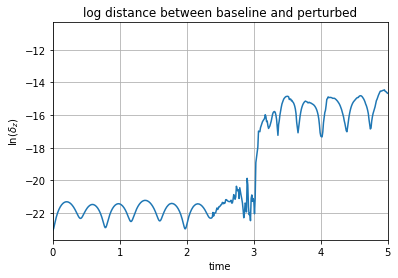

In [25]:
run = runs[conditions[4]]
plt.plot(run['baseline'].times, np.log(run['deltaz']))
plt.xlabel("time")
plt.ylabel(r"$\ln(\delta_z)$")
plt.title("log distance between baseline and perturbed")
plt.xlim(0,5)
plt.grid()

In [26]:
runs[conditions[5]]['baseline'].times[np.argmax(runs[conditions[5]]['deltaz'] > np.exp(-20))]

In [27]:
def time_of_jump(initial_conditions, pert=1.0e-10, jump_threshold=1e-8):
    """Find the time of the jump given a set of initial conditions.
    
    For a perturbation of 1e-10, I'm going to call the time the value of deltaz
    first passes e^-20 the time of the jump. I determined this threshold visually
    from our data.
    
    This function includes import statements to make it parallel-friendly.
    """
    import multipendulum as mp
    import numpy as np
    
    theta_0, theta_1, theta_0dot, theta_1dot = initial_conditions

    baseline = mp.MultiPendulum(2)
    baseline.set_initial_conditions((theta_0, theta_1),
                                    (theta_0dot, theta_1dot), degrees=False, eigenmodes=False)
    perturbed = mp.MultiPendulum(2)
    perturbed.set_initial_conditions((theta_0, theta_1+1e-10),
                                     (theta_0dot, theta_1dot), degrees=False, eigenmodes=False)
    baseline.integrate()
    perturbed.integrate()
    deltazvec = baseline.timeseries - perturbed.timeseries
    deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

    time = baseline.times[np.argmax(deltaz>np.exp(-20))]
    return time

In [28]:
time_of_jump(conditions[4])

In [29]:
theta_1_vals = np.linspace(-0.13, 0.13, 601)
conditions = [(bisect(buildwrapper(i), 0, 1), i, 0, 0) for i in theta_1_vals]

## Possible Causes

### algorithmic

#### truncation error in odeint
If this is the case, we'd expect to be able to affect the timing and/or magnitude of the jump by changing step size.

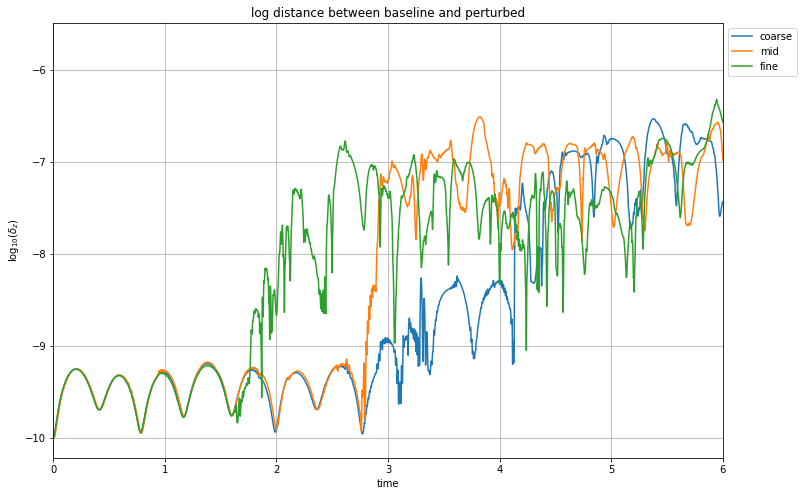

In [36]:
coarsetime = np.linspace(0,20,10000)
midtime = np.linspace(0,20,20000)
finetime = np.linspace(0,20,40000)

baseline = mp.MultiPendulum(2)
baseline.times = midtime
baseline.set_initial_conditions((0.085,-0.075), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()

modetwo = mp.MultiPendulum(2)
modetwo.times = midtime
modetwo.set_initial_conditions((0.085,-0.075+1.0e-10), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

baseline.times = coarsetime
modetwo.times = coarsetime
baseline.integrate()
modetwo.integrate()
deltazvec_coarse = baseline.timeseries - modetwo.timeseries
deltaz_coarse = np.sqrt(np.sum(deltazvec_coarse**2, axis=1))

baseline.times = finetime
modetwo.times = finetime
baseline.integrate()
modetwo.integrate()
deltazvec_fine = baseline.timeseries - modetwo.timeseries
deltaz_fine = np.sqrt(np.sum(deltazvec_fine**2, axis=1))

plt.plot(coarsetime, np.log10(deltaz_coarse),label="coarse")
plt.plot(midtime, np.log10(deltaz),label="mid")
plt.plot(finetime, np.log10(deltaz_fine),label="fine")

plt.xlabel("time")
plt.ylabel(r"$\log_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
leg = plt.legend(loc="upper left")
plt.xlim(0,6)
leg.set_bbox_to_anchor((1,1))
fig = plt.gcf()
fig.set_figwidth(12)
fig.set_figheight(8)
plt.grid()

This makes the effect look related to the number of steps-- the jump happens faster with the finer resolution.

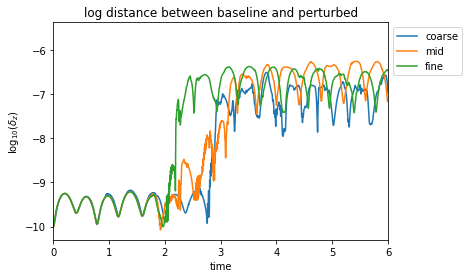

In [37]:
coarsetime = np.linspace(0,20,20000)
midtime = np.linspace(0,20,100000)
finetime = np.linspace(0,20,500000)

baseline = mp.MultiPendulum(2)
baseline.times = midtime
baseline.set_initial_conditions((0.085,-0.075), (0,0), degrees=False, eigenmodes=False)
baseline.integrate()

modetwo = mp.MultiPendulum(2)
modetwo.times = midtime
modetwo.set_initial_conditions((0.085,-0.075+1.0e-10), (0.0,0.0), degrees=False, eigenmodes=False)
modetwo.integrate()

deltazvec = baseline.timeseries - modetwo.timeseries
deltaz = np.sqrt(np.sum(deltazvec**2, axis=1))

baseline.times = coarsetime
modetwo.times = coarsetime
baseline.integrate()
modetwo.integrate()
deltazvec_coarse = baseline.timeseries - modetwo.timeseries
deltaz_coarse = np.sqrt(np.sum(deltazvec_coarse**2, axis=1))

baseline.times = finetime
modetwo.times = finetime
baseline.integrate()
modetwo.integrate()
deltazvec_fine = baseline.timeseries - modetwo.timeseries
deltaz_fine = np.sqrt(np.sum(deltazvec_fine**2, axis=1))

plt.plot(coarsetime, np.log10(deltaz_coarse),label="coarse")
plt.plot(midtime, np.log10(deltaz),label="mid")
plt.plot(finetime, np.log10(deltaz_fine),label="fine")

plt.xlabel("time")
plt.ylabel(r"$\log_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
leg = plt.legend(loc="upper left")
plt.xlim(0,6)
leg.set_bbox_to_anchor((1,1))

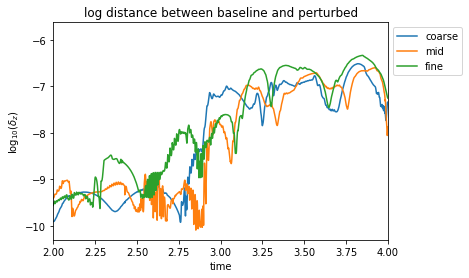

In [31]:
plt.plot(coarsetime, np.log10(deltaz_coarse),label="coarse")
plt.plot(midtime, np.log10(deltaz),label="mid")
plt.plot(finetime, np.log10(deltaz_fine),label="fine")

plt.xlabel("time")
plt.ylabel(r"$\log_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
leg = plt.legend(loc="upper left")
plt.xlim(2,4)
leg.set_bbox_to_anchor((1,1))

Once the resolution gets high enough (i.e., there are enough steps), the timing of the jump is no longer dependent on the number of steps.

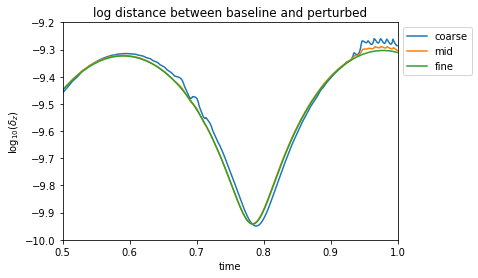

In [32]:
plt.plot(coarsetime, np.log10(deltaz_coarse),label="coarse")
plt.plot(midtime, np.log10(deltaz),label="mid")
plt.plot(finetime, np.log10(deltaz_fine),label="fine")

plt.xlabel("time")
plt.ylabel(r"$\log_{10}(\delta_z)$")
plt.title("log distance between baseline and perturbed")
leg = plt.legend(loc="upper left")
plt.xlim(0.5,1)
plt.ylim(-10,-9.2)
leg.set_bbox_to_anchor((1,1))

#### precision issues with np.linalg.solve
If this is the case, we'd expect to be able to find points in phase space where the matrix being inverted has a large condition number.

**Spoiler:** the condition number is never big enough to cause the degree of precision loss we would need to get the observed effect.

#### precision issues with lambdify
I'm not yet sure how to test this.

In [24]:
np.info(np.arctan2)

arctan2(x1, x2, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Element-wise arc tangent of ``x1/x2`` choosing the quadrant correctly.

The quadrant (i.e., branch) is chosen so that ``arctan2(x1, x2)`` is
the signed angle in radians between the ray ending at the origin and
passing through the point (1,0), and the ray ending at the origin and
passing through the point (`x2`, `x1`).  (Note the role reversal: the
"`y`-coordinate" is the first function parameter, the "`x`-coordinate"
is the second.)  By IEEE convention, this function is defined for
`x2` = +/-0 and for either or both of `x1` and `x2` = +/-inf (see
Notes for specific values).

This function is not defined for complex-valued arguments; for the
so-called argument of complex values, use `angle`.

Parameters
----------
x1 : array_like, real-valued
    `y`-coordinates.
x2 : array_like, real-valued
    `x`-coordinates. `x2` must be broadcastable to match the shape of
    `x

### Model V&V

The problem comes from the error estimates built into the adaptive integration stepsize. By default both the absolute and relative errors are set to about 1.5e-8 (which is more or less the size of the jump). Requiring tighter tolerances makes the jump go away.